# Ejemplo de PCA

## Objetivos

1. Comprender e interpretar la correlación entre diferentes características de un conjunto de datos.
2. Aplicar PCA en un conjunto de datos del mundo real y comprender cuántos datos se almacenan en qué componentes.
3. Visualizar datos de alta dimensión reduciéndolos primero a dos dimensiones usando PCA y luego representándolos.
4. Observar cómo varía el rendimiento de un modelo con el número de componentes principales utilizados.

Analizaremos el conjunto de datos de cáncer de mama de sklearn. Primero cargaremos el conjunto de datos y lo dividiremos en conjuntos de entrenamiento y prueba. Luego, realizaremos una regresión logística en el conjunto de entrenamiento y evaluaremos nuestro modelo en el conjunto de prueba. Habiendo hecho eso, visualizaremos y analizaremos las correlaciones en los datos. Exploraríamos cómo PCA nos ayuda a comprimir los datos y proyectarlos en dos dimensiones para que podamos trazarlos. Por último, realizaremos una regresión logística en los datos comprimidos y veremos cómo se compara con el rendimiento del modelo en los datos originales.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Usaremos el conjunto de datos de cáncer de mama de sklearn en este cuaderno. Este conjunto de datos contiene información sobre tumores malignos y benignos. Nuestro objetivo es crear un modelo que pueda clasificar un tumor como maligno o benigno.

## El conjunto de datos

In [2]:
dat = datasets.load_breast_cancer()
print(dat.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [3]:
df_all = pd.DataFrame(dat['data'], columns=list(dat['feature_names']))
df_all.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Creación de conjuntos de prueba y de entrenamiento

Para permitir que nuestro modelo haga predicciones sobre si un tumor es maligno o benigno, necesitamos entrenarlo a partir de algunos datos para luego evaluar el rendimiento de nuestro modelo. Debemos verificar que clasifica correctamente los datos no vistos. Es por eso que dividimos los datos que tenemos en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. Entrenamos los parámetros para el modelo usando el conjunto de entrenamiento y luego evaluamos qué tan bueno es el modelo usando el conjunto de prueba.

Tomamos el 70 % de las muestras en el conjunto de entrenamiento y el 30 % en el conjunto de prueba, lo cual es convencional para el tamaño del conjunto de datos que tenemos.

In [4]:
TEST_TAMAÑO = 0.3


X = df_all
y = pd.Series(list(dat['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_TAMAÑO, random_state=0)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

X_train.shape, y_train.shape (398, 30) (398,)
X_test.shape, y_test.shape (171, 30) (171,)


## Regresión logística

Ahora realizaremos una regresión logística en los datos no modificados.

En este caso, las clases son malignas (representadas por el número 0) y benignas (representadas por el número 1). Según los datos, intentaríamos clasificar un tumor como maligno o benigno.

Para evaluar el rendimiento del modelo, utilizaremos una métrica llamada "f1 score", que evalúa qué tan bien el modelo predice si un tumor es maligno o benigno y otorga una puntuación numérica basada en eso. Nuestro objetivo es conseguir que la puntuación de f1 sea lo más alta posible.

In [5]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train)))
print("Testing score: ", f1_score(y_test, model.predict(X_test)))

Training score:  0.99203187250996
Testing score:  0.981651376146789


Cuando entrenamos el modelo con los datos iniciales (normalizados), obtenemos una puntuación del conjunto de prueba del 98,17 %.

## Visualización de la correlación de las características

Matriz de correlación: X.shape, y.shape, yX.shape: (569, 30) (569,) (569, 31)



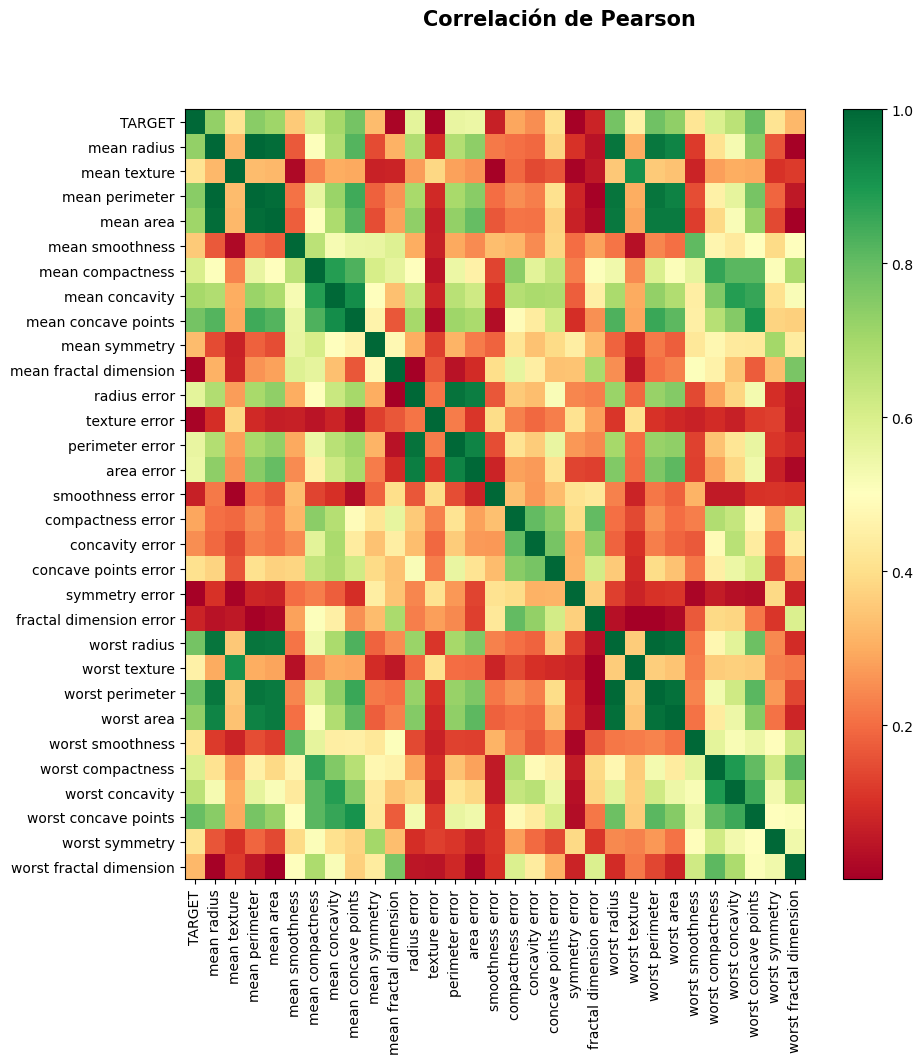

In [6]:
def correlation_matrix(y, X, is_plot=False):
    yX = pd.concat([y, X], axis=1)
    yX = yX.rename(columns={0: 'TARGET'})  

    print("Matriz de correlación: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
    print()

  
    yX_corr = yX.corr(method='pearson')

  
    yX_abs_corr = np.abs(yX_corr) 
  
    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
        plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
        plt.suptitle('Correlación de Pearson', fontsize=15, fontweight='bold')
        plt.show()
  
    return yX, yX_corr, yX_abs_corr


yX, yX_corr, yX_abs_corr = correlation_matrix(y, X, is_plot=True) 

La etiqueta `TARGET` anterior se refiere a si el tumor es maligno (0) o benigno (1). Las celdas verdes indican una correlación muy alta, mientras que las celdas rojas indican una correlación muy baja.

En el gráfico anterior, podemos ver que el `mean radius` y el `mean perimeter` están fuertemente correlacionados entre sí (la correlación es casi igual a 1). El `mean radius` y el `mean area` también están fuertemente relacionados entre sí. Sin embargo, `worst fractal dimension` y el `mean radius` no tienen ninguna relación entre sí (la correlación es casi igual a 0). 

Podemos eliminar algunas de estas características y combinar las otras y aun así perder solo una cantidad mínima de información. Esto es lo que haremos en la siguiente sección cuando apliquemos PCA a los datos.


## PCA 


Ahora realizaremos PCA en nuestro conjunto de entrenamiento. Esto se puede hacer de manera trivial usando la biblioteca sklearn. Tenga en cuenta que la base propia se calcula utilizando solo los puntos de datos en el conjunto de entrenamiento. Esto se debe a que el modelo también debería funcionar bien con datos no vistos. Si incluimos datos sobre el conjunto de prueba cuando encontramos la base propia, nuestro modelo podría verse sesgado y el conjunto de prueba ya no proporcionaría un juicio imparcial de nuestro modelo.

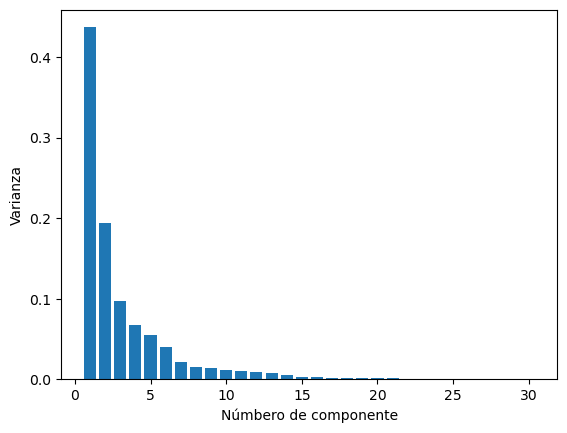

In [7]:

pca = PCA()
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)


plt.ylabel('Varianza')
plt.xlabel('Númbero de componente')
plt.bar(np.arange(30) + 1, pca.explained_variance_ratio_)
plt.show()

Como puede ver, la cantidad de información almacenada en un componente es realmente alta para las primeras dimensiones, pero luego cae muy rápidamente. Solo el 1,4% de la varianza se almacena en el 7º componente. Además, cae a un 0,25% completamente insignificante en el componente 16. Retenemos casi el 85 % de la varianza de los datos originales al usar solo 5 componentes, que es una sexta parte del número de características de los datos originales.


In [8]:
print(pca.explained_variance_ratio_)

[4.36893153e-01 1.94151626e-01 9.66154484e-02 6.71661075e-02
 5.49883033e-02 4.01225718e-02 2.18306816e-02 1.48922601e-02
 1.37410827e-02 1.10137130e-02 1.04826288e-02 9.16214247e-03
 7.66306051e-03 5.14226331e-03 3.19635178e-03 2.51968451e-03
 1.92415148e-03 1.65844223e-03 1.49026749e-03 1.06777316e-03
 1.01725216e-03 8.48954816e-04 7.43492725e-04 5.81295611e-04
 5.44222785e-04 2.53545469e-04 2.14385701e-04 4.62967124e-05
 2.51158320e-05 3.72534805e-06]


## Visualización 

PCA nos permite proyectar nuestros datos originales en un espacio bidimensional. Esto nos permite visualizar los datos trazándolos en un gráfico. A continuación, visualizaremos el conjunto de entrenamiento realizando PCA en él y considerando solo los primeros 2 componentes.

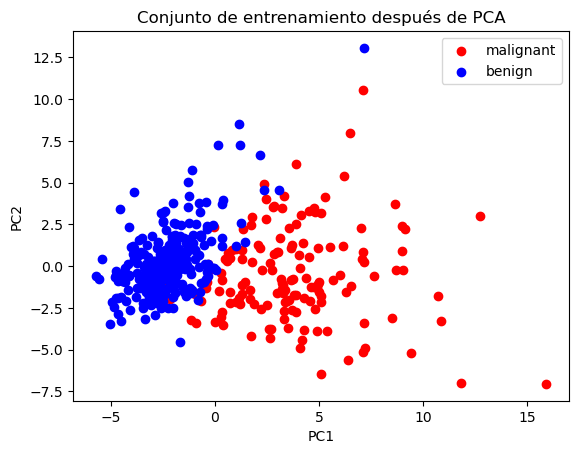

In [9]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

X_train_reduced_malignant = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 0])
X_train_reduced_benign = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 1])

plt.scatter(*X_train_reduced_malignant.T, color='red')
plt.scatter(*X_train_reduced_benign.T, color='blue')
plt.title('Conjunto de entrenamiento después de PCA')
plt.legend(['malignant', 'benign'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Regresión Logística

Ahora realizaremos la regresión logística nuevamente, pero esta vez primero realizaremos PCA en los datos y solo consideraremos los primeros 5 componentes.

In [10]:
pca = PCA(n_components=5)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train_reduced)))
print("Testing score: ", f1_score(y_test, model.predict(X_test_reduced)))

Training score:  0.9859719438877755
Testing score:  0.9769585253456222


Esta vez obtenemos una puntuación del conjunto de pruebas del 97,7 %, que es sólo marginalmente peor que la puntuación original del 98,17 %. Sin embargo, al usar solo una sexta parte de la cantidad de datos que habíamos usado inicialmente, nuestro modelo se entrenará mucho más rápido. Si bien es posible que el efecto no se note en este caso, puede ser enorme en ciertas aplicaciones, en las que, de lo contrario, los modelos podrían haber tardado muchos días en entrenarse.

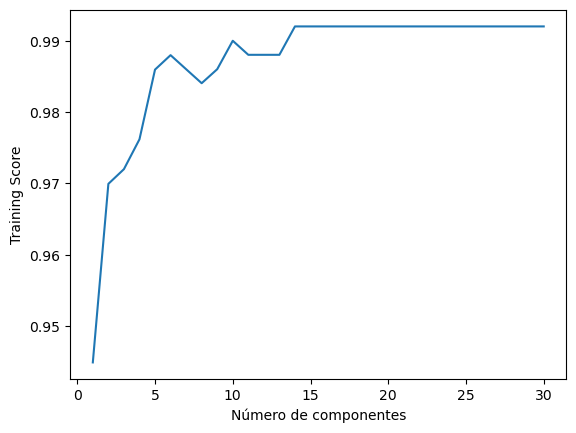

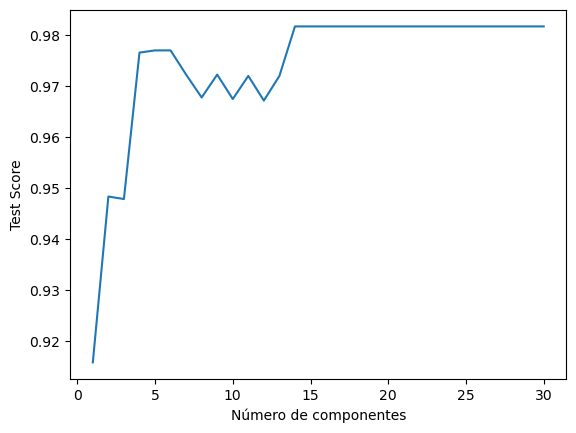

In [11]:
X = np.arange(30) + 1
Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_train, model.predict(X_train_reduced)))

plt.plot(X, Y)
plt.xlabel('Número de componentes')
plt.ylabel('Training Score')
plt.show()

Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_test, model.predict(X_test_reduced)))

plt.plot(X, Y)
plt.xlabel('Número de componentes')
plt.ylabel('Test Score')
plt.show()